# Simple seq2seq model in keras that translates english <-> german

As a next step I take the model used for the [toy problem of adding/subtracting numbers](SimpleModelForAddingAndSubstraction.ipynb) and train it with english/german data for machine translation.

As training set I use the [European Parliament Proceedings Parallel Corpus 1996-2011](http://statmt.org/europarl/) German-English corpus. I'm preprocessing the dataset (lowercase, replace numbers with 0) as I will later train it with a pretrained bytepair embedding for such a preprocessed dataset and so I get comparable results. For an application it wouldn't be much of a practical problem to train bytepair embeddings if needed.

I'll train it now on medium length sentences (up to 50 characters in english, 65 characters in german), so we can see problems from handling longer sentences (losing focus and similiar). In the end I'll show results for a mini test set (unknown, short own written english->german samples) and for sentences from the training and validation set. To have a reasonable automatic scoring, I'll use BLEU scoring (with smoothing) on a part of the validation set.

The code for the seq2seq part is close to be the same as for the toy problem. For the batch trainings, I had to write a batch generator (as the one-hot-encoded output sequence wouldn't fit into memory when using bytepairs). Also, I added a dropout layer after the decoder GRU to reduce overfitting. I also tweaked a bit hyperparameters (lower learning rate, reduced batch size again to reduce memory consumption)

In [1]:
# technical detail so that an instance (maybe running in a different window)
# doesn't take all the GPU memory resulting in some strange error messages
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

/home/janek/.local/share/virtualenvs/rosetta-WKmHhL03/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import math
import matplotlib.pyplot as plt
import os
import re
import tarfile

import keras
import keras.layers as L
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

# Fixing random state ensure reproducible results
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
tf.set_random_seed(RANDOM_STATE)

In [3]:
START = '^'
END = '\n'

MAX_INPUT_LENGTH = 50
MAX_TARGET_LENGTH = 65
LATENT_DIM = 512
EMBEDDING_DIM = 64
EPOCHS = 20
BATCH_SIZE = 64
DROPOUT = 0.5
TEST_SIZE = 500

## Download and explore data

In [4]:
def download_file(fname, url):
    print(f"Downloading {fname} from {url} ...")
    response = requests.get(url, stream=True)

    total_size = int(response.headers.get('content-length', 0)); 
    block_size = 1024

    download = tqdm(
        response.iter_content(block_size),
        total=math.ceil(total_size // block_size),
        unit='KB',
        unit_scale=True
    )
    with open(f"{fname}", "wb") as handle:
        for data in download:
            handle.write(data)

PATH = 'data'
FILES = {
    'de-en.tgz': 'http://statmt.org/europarl/v7/de-en.tgz',  # incredible: really only http, not https :-o
}
os.makedirs(PATH, exist_ok=True)

for name, url in FILES.items():
    fname = os.path.join(PATH, name)
    exists = os.path.exists(fname)
    size = os.path.getsize(fname) if exists else -1
    if exists and size > 0:
        print(f'{name} already downloaded ({size / 2**20:3.1f} MB)')
        continue
    download_file(fname, url)
    if (fname.endswith(".tgz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path=PATH)
        tar.close()
        print(f'Extracted {fname} ...')


de-en.tgz already downloaded (188.6 MB)


In [5]:
# Following https://github.com/bheinzerling/bpemb/blob/master/preprocess_text.sh
# (ignoring urls as there shouldn't be any in parliament discussions)
def preprocess(line):
    line = re.sub(r'\d+', '0', line)  # replace all numbers by '0'
    line = re.sub(r'\s+', ' ', line)  # strip whitespaces as a ' '
    return line.lower().strip()

def read_corpus_lines(language):
    return [preprocess(line) for line in open(f'{PATH}/europarl-v7.de-en.{language}', 'r').readlines()]
    
pd.set_option('max_colwidth', 60)
df = pd.DataFrame(data={
    'input_texts': read_corpus_lines('en'),
    'target_texts': read_corpus_lines('de'), 
})
df.input_texts = START + df.input_texts + END
df.target_texts = START + df.target_texts + END

In [6]:
len(df)
df['input_length'] = df.input_texts.apply(len)
df['target_length'] = df.target_texts.apply(len)
df.head()

1920209

,input_texts,target_texts,input_length,target_length
0,^resumption of the session\n,^wiederaufnahme der sitzungsperiode\n,27,36
1,^i declare resumed the session of the european parliamen...,"^ich erkläre die am freitag, dem 0. dezember unterbroche...",205,219
2,"^although, as you will have seen, the dreaded 'millenniu...","^wie sie feststellen konnten, ist der gefürchtete ""mille...",193,187
3,^you have requested a debate on this subject in the cour...,^im parlament besteht der wunsch nach einer aussprache i...,107,112
4,"^in the meantime, i should like to observe a minute' s s...",^heute möchte ich sie bitten - das ist auch der wunsch e...,234,219


### Only use short translations right now

So, first I plot sentence length on a logarithmic scale, 
then I only choose short input texts (and a bit longer target texts as german is more verbose than english).

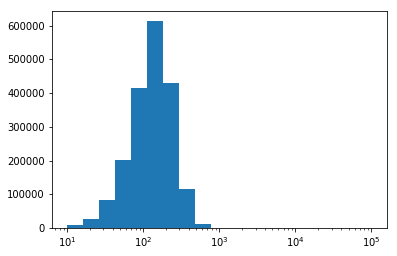

In [7]:
x = df.input_length
logbins = np.logspace(1,5,20)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show();

In [8]:
non_empty = (df.input_length > 3) & (df.target_length > 3)  # there are empty phrases like '\n' --> 'Frau Präsidentin\n'
short_inputs = (df.input_length < MAX_INPUT_LENGTH + 2) & (df.target_length < MAX_TARGET_LENGTH + 2)  # add start + end symbols
sum(non_empty & short_inputs)
df = df[non_empty & short_inputs]

167211

In [9]:
corpus = pd.concat([df.input_texts, df.target_texts])

In [10]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=100, filters=None, char_level=True, oov_token='~')
tokenizer.fit_on_texts(corpus)
df['input_sequences'] = tokenizer.texts_to_sequences(df.input_texts)
df['target_sequences'] = tokenizer.texts_to_sequences(df.target_texts)

In [11]:
list(reversed(sorted(tokenizer.word_counts.items(), key=lambda d: d[1])))
sum(1 for w, count in tokenizer.word_counts.items() if count > 1000)

[(' ', 1656706),
 ('e', 1393381),
 ('i', 830566),
 ('t', 817881),
 ('n', 783850),
 ('s', 714344),
 ('a', 653289),
 ('r', 643182),
 ('o', 490686),
 ('h', 486235),
 ('d', 382862),
 ('l', 353517),
 ('\n', 334422),
 ('^', 334422),
 ('u', 322169),
 ('c', 287330),
 ('m', 270604),
 ('.', 268267),
 ('g', 229490),
 ('w', 193711),
 ('b', 165185),
 ('p', 158586),
 ('f', 158468),
 ('k', 110148),
 ('v', 94920),
 ('y', 79537),
 ('z', 57233),
 (',', 50769),
 ('0', 48071),
 ('ü', 35607),
 ('ä', 30461),
 ('(', 28874),
 (')', 27913),
 ('?', 26063),
 ('-', 15932),
 ('j', 15901),
 ('ö', 13841),
 (':', 12059),
 ('!', 12003),
 ('ß', 11001),
 ('x', 9319),
 ('q', 8628),
 ('/', 6557),
 ("'", 3757),
 ('"', 1769),
 ('%', 1066),
 ('–', 897),
 ('’', 406),
 (';', 388),
 ('é', 387),
 ('á', 302),
 ('í', 292),
 ('ó', 216),
 ('‘', 129),
 ('“', 127),
 ('„', 120),
 ('è', 107),
 (']', 57),
 ('…', 56),
 ('à', 56),
 ('[', 56),
 ('š', 43),
 ('æ', 39),
 ('ł', 38),
 ('ú', 33),
 ('ç', 32),
 ('ñ', 30),
 ('č', 29),
 ('ï', 29),
 (

46

In [12]:
max_len_input = df.input_length.max()
max_len_target = df.target_length.max()
nr_tokens = len(tokenizer.word_index) + 1  # add 0 padding not in word_index contained

# one hot encoded y_t_output wouldn't fit into memory any longer
# so need to train/validate on batches generated on the fly
def create_batch_generator(samples_ids):
    
    def batch_generator():
        nr_batches = np.ceil(len(samples_ids) / BATCH_SIZE)
        while True:
            shuffled_ids = np.random.permutation(samples_ids)
            batch_splits = np.array_split(shuffled_ids, nr_batches)
            for batch_ids in batch_splits:
                batch_X = pad_sequences(df.iloc[batch_ids].input_sequences, padding='post', maxlen=max_len_input)
                batch_y = pad_sequences(df.iloc[batch_ids].target_sequences, padding='post', maxlen=max_len_target)
                batch_y_t_output = keras.utils.to_categorical(batch_y[:,1:], num_classes=len(tokenizer.word_index)+1)
                batch_x_t_input = batch_y[:,:-1]
                yield ([batch_X, batch_x_t_input], batch_y_t_output)
    
    return batch_generator()

In [13]:
train_ids, val_ids = train_test_split(np.arange(df.shape[0]), test_size=0.1)

In [14]:
nr_tokens
len(tokenizer.word_index)
len(train_ids), len(val_ids)

162

161

(150489, 16722)

In [15]:
encoder_gru = L.Bidirectional(
    L.GRU(LATENT_DIM // 2, dropout=DROPOUT, return_state=True, name='encoder_gru'),
    name='encoder_bidirectional'
)
decoder_gru = L.GRU(LATENT_DIM, dropout=DROPOUT, return_sequences=True, return_state=True, name='decoder_gru')
decoder_dense = L.Dense(nr_tokens, activation='softmax', name='decoder_outputs')

shared_embedding = L.Embedding(nr_tokens, EMBEDDING_DIM, mask_zero=True, name='shared_embedding')

encoder_inputs = L.Input(shape=(max_len_input, ), dtype='int32', name='encoder_inputs')
encoder_embeddings = shared_embedding(encoder_inputs)
_, encoder_state_1, encoder_state_2 = encoder_gru(encoder_embeddings)
encoder_states = L.concatenate([encoder_state_1, encoder_state_2])

decoder_inputs = L.Input(shape=(max_len_target-1, ), dtype='int32', name='decoder_inputs')
decoder_mask = L.Masking(mask_value=0)(decoder_inputs)
decoder_embeddings_inputs = shared_embedding(decoder_mask)
decoder_embeddings_outputs, _ = decoder_gru(decoder_embeddings_inputs, initial_state=encoder_states) 
decoder_outputs = decoder_dense(decoder_embeddings_outputs)


model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

inference_encoder_model = Model(encoder_inputs, encoder_states)
    
inference_decoder_state_inputs = L.Input(shape=(LATENT_DIM, ), dtype='float32', name='inference_decoder_state_inputs')
inference_decoder_embeddings_outputs, inference_decoder_states = decoder_gru(
    decoder_embeddings_inputs, initial_state=inference_decoder_state_inputs
)
inference_decoder_outputs = decoder_dense(inference_decoder_embeddings_outputs)

inference_decoder_model = Model(
    [decoder_inputs, inference_decoder_state_inputs], 
    [inference_decoder_outputs, inference_decoder_states]
)

In [16]:
model.summary()
inference_decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, 65)           0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 65)           0           decoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     (None, 51)           0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    multiple             10368       encoder_inputs[0][0]             
                                                                 masking_1[0][0]                  
__________

In [17]:
model.compile(optimizer=keras.optimizers.Adam(clipnorm=1., clipvalue=.5), loss='categorical_crossentropy')

In [18]:
train_generator = create_batch_generator(train_ids)
val_generator = create_batch_generator(val_ids)
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(len(train_ids) / BATCH_SIZE),
    epochs=20,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_ids) / BATCH_SIZE),
)

Epoch 1/20
2352/2352 [==============================] - 338s 144ms/step - loss: 1.3357 - val_loss: 0.9149
Epoch 2/20
2352/2352 [==============================] - 335s 142ms/step - loss: 0.8936 - val_loss: 0.8118
Epoch 3/20
2352/2352 [==============================] - 340s 145ms/step - loss: 0.8162 - val_loss: 0.7631
Epoch 4/20
2352/2352 [==============================] - 344s 146ms/step - loss: 0.7749 - val_loss: 0.7392
Epoch 5/20
2352/2352 [==============================] - 347s 147ms/step - loss: 0.7480 - val_loss: 0.7207
Epoch 6/20
2352/2352 [==============================] - 313s 133ms/step - loss: 0.7290 - val_loss: 0.7095
Epoch 7/20
2352/2352 [==============================] - 322s 137ms/step - loss: 0.7150 - val_loss: 0.6980
Epoch 8/20
2352/2352 [==============================] - 346s 147ms/step - loss: 0.7038 - val_loss: 0.6907
Epoch 9/20
2352/2352 [==============================] - 345s 146ms/step - loss: 0.6943 - val_loss: 0.6869
Epoch 10/20
2352/2352 [=======================

In [19]:
def decode_sequence(input_seq):
    states_value = inference_encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, max_len_target-1))
    target_seq[0, 0] = tokenizer.word_index[START]
    
    tokens = {idx: token for (token, idx) in tokenizer.word_index.items()}
    
    decoded_sequence = ''
    for i in range(max_len_target):
        output_tokens, output_states = inference_decoder_model.predict(
            [target_seq, states_value]
        )
        
        # greedy search
        sampled_token_idx = np.argmax(output_tokens[0, 0, :])
        sampled_token = tokens.get(sampled_token_idx, '.')
        if sampled_token == END:
            break
        decoded_sequence += sampled_token
            
        target_seq[0, 0] = sampled_token_idx
        states_value = output_states
    
    return decoded_sequence 

In [20]:
def predict(sentence):
    return decode_sequence(keras.preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences([preprocess(sentence)]),
        padding='post',
        maxlen=max_len_input,
    ))

In [21]:
# Performance on some examples:
EXAMPLES = [
    'Hello.',
    'You are welcome.',
    'How do you do?',
    'I hate mondays.',
    'I am a programmer.',
    'Data is the new oil.',
    'It could be worse.',
    "I am on top of it.",
    "N° Uno",
    "Awesome!",
    "Put your feet up!",
    "From the start till the end!",
    "From dusk till dawn.",
]
for en in [sentence + '\n' for sentence in EXAMPLES]:
    print(f"{preprocess(en)!r} --> {predict(en)!r}")

'hello.' --> 'dank.'
'you are welcome.' --> 'das wissen wir alle.'
'how do you do?' --> 'wie soll das geschehen?'
'i hate mondays.' --> 'ich habe mit der geschäftsordnung geben.'
'i am a programmer.' --> 'ich bin eine gemeinsame priorität.'
'data is the new oil.' --> 'bedeutet das gegenteil.'
'it could be worse.' --> 'er kann das ergebnissen bestehen.'
'i am on top of it.' --> 'ich bin dazu bereits gesagt.'
'n° uno' --> 'eine antwort auf den tag für eine antwort!'
'awesome!' --> 'machen wir uns alle!'
'put your feet up!' --> 'das ist eine gute nachricht!'
'from the start till the end!' --> 'was für ein gutes beispiel dafür?'
'from dusk till dawn.' --> 'die geschichte haben in der tat geschehen.'


In [22]:
# Performance on training set:
for en, de in df[['input_texts', 'target_texts']][1:20].values.tolist():
    print(f"Original {preprocess(en)!r}, got {predict(en)!r}, exp: {de[1:]!r}")

Original "^please rise, then, for this minute' s silence.", got 'bitte bedanken sie diese frage an dieser stelle.', exp: 'ich bitte sie, sich zu einer schweigeminute zu erheben.\n'
Original "^(the house rose and observed a minute' s silence)", got '(das parlament erhebt sich zu einer schweigeminute.)', exp: '(das parlament erhebt sich zu einer schweigeminute.)\n'
Original '^madam president, on a point of order.', got 'frau präsidentin, zur geschäftsordnung.', exp: 'frau präsidentin, zur geschäftsordnung.\n'
Original '^madam president, on a point of order.', got 'frau präsidentin, zur geschäftsordnung.', exp: 'frau präsidentin, zur geschäftsordnung.\n'
Original '^thank you, mr segni, i shall do so gladly.', got 'vielen dank, herr barroso, ich danke ihnen dafür.', exp: 'vielen dank, herr segni, das will ich gerne tun.\n'
Original '^it is the case of alexander nikitin.', got 'das ist die situation von kontrolle.', exp: 'das ist der fall von alexander nikitin.\n'
Original '^it will, i hope

In [23]:
# Performance on validation set
val_df = df.iloc[val_ids]
for en, de in val_df[['input_texts', 'target_texts']][1:20].values.tolist():
    print(f"Original {preprocess(en)!r}, got {predict(en)!r}, exp: {de[1:]!r}")

Original '^perhaps there is a connection.', got 'vielleicht ist ein großer fehler.', exp: 'vielleicht besteht da ein zusammenhang.\n'
Original '^(applause)', got '(beifall)', exp: '(beifall)\n'
Original '^mr president, what is going on?', got 'herr präsident, wir werden das tun?', exp: 'herr präsident! was steckt dahinter?\n'
Original '^it is something that we must do ourselves.', got 'das müssen wir uns alle einigen.', exp: 'es ist etwas, das wir selbst tun müssen.\n'
Original "^no reform'.", got 'nie wieder kommen.', exp: 'keine reform."\n'
Original '^there must be no more lockerbies.', got 'es muss keine gewinner sein.', exp: 'es darf keine lockerbies mehr geben.\n'
Original '^the european union must lead by example.', got 'die europäische union muss geleistet werden.', exp: 'die europäische union muss mit gutem beispiel vorangehen.\n'
Original '^that is the point.', got 'das ist das problem.', exp: 'darum geht es.\n'
Original '^it is as simple as that.', got 'das ist genau das gege

In [24]:
import spacy
try:
    from spacy.lang.de import German
except ModuleNotFoundError:
    spacy.cli.download('de')
    from spacy.lang.de import German
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

parser = German()
chencherry = SmoothingFunction()  # to handle short sequences, see also http://www.nltk.org/_modules/nltk/translate/bleu_score.html#SmoothingFunction.method3

def remove_spaces_and_puncts(tokens):
     return [token.orth_ for token in tokens if not (token.is_space or token.is_punct)]  

bleu_scores = np.zeros(TEST_SIZE)
nist_scores = np.zeros(TEST_SIZE)

for i in tqdm(range(TEST_SIZE)):
    pred_tokens = remove_spaces_and_puncts(parser(predict(df.iloc[val_ids[i]].input_texts)))
    ref_tokens = remove_spaces_and_puncts(parser(df.iloc[val_ids[i]].target_texts[1:]))
    bleu_scores[i] = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=chencherry.method3)
    
print("Average bleu score:", bleu_scores.mean())


Average bleu score: 0.2131365083574276


In [25]:
name = 'simple_char_mt'
model.save_weights(f'data/{name}_model_weights.h5')  # https://drive.google.com/open?id=1f7DuteA2qU3mkzEGOr3cjeVToiBBmCB_
inference_encoder_model.save_weights(f'data/{name}_inference_encoder_model_weights.h5')  # https://drive.google.com/open?id=1OWOCDhVCoTNKkwoaZMPg0IFEW4vJnb01
inference_decoder_model.save_weights(f'data/{name}_inference_decoder_model_weights.h5')  # https://drive.google.com/open?id=1IfRbB1F-ivdLsjuMUYBAxsQ5OzSRcGi1

# Conclusion

From a technical point of view it's nice to see that overfitting doesn't matter due to the relatively large dataset of 150k training dataset. (It seemed to be a problem when playing around with a small dataset)

It's obvious that the seq2seq-model learned to write german sentences, but on the other hand, they aren't really appropriate translations. Often enough they are completely wrong. We'll need improvements. My first step will be to use a higher than char-level embedding, in my case bytepairencoding embedding. To really train end-to end char-level, the usual guidance is that we need training data in the millions - ok, here we would have (but most of the training data would be very long sentences where we'd get further problems with RNNs without attentions, also already this training needs ~2h on a GTX 1080 GPU). So, my next step will be to use bytepairencoding embeddings and after that implementing Beam Search instead of Greedy Search and Attention Mechanism.